<h1>Preliminary Sampling Experimentation</h1>

This notebook will investigate approaches to sampling data to fit a negative exponential function $\rho = 2^{-d/D}$. The function itself will be used to generate artificial data, with some noise added to each $\rho$ value. For a fixed grid cell, the function parameters can be interpreted as follows: $d$ represents distance to a grid cell, $D$ represents correlation distance, and $\rho$ represents correlation to that grid cell.

First, the packages needed for the experiment are imported and the font size for figures is set.

In [252]:
#import packages and define the model to sample from
from math import sqrt
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt
font = {
        'weight' : 'bold',
        'size'   : 14}

plt.rc('font', **font)

<h2>Generating Noisy Artificial Data</h2>

The following are two of the functions used for the experiment. The first is the negative exponential function presented before.

The second function calls the first to generate a value of $\rho$ for a given $d$ value input. The parameter $D$ is fixed as 400 for data generation. The noise is simulated by adding a value to $\rho$ that was sampled from a normal distribution with mean = 0 and standard deviation taken as an input. The standard deviation is chosen to be small enough to not cause deviations from the negative exponential curve, but should be big enough to introduce adequate noise in the results.

In [253]:
#np.random.seed(0)

# LPS: I've un-hardcoded the true value as we might want to play with this later. 
ValueTRUE = 400

#function to calculate correlation (rho) for distance to cell, d, and correlation distance, D
def cordist(d,D): 
    rho = 2**(-d/D)
    return(rho)


#generate correlation value using the function above, with corr. distance fixed  (D=400km). Distance to grid cell, d, is the input parameter. 
def generate_value(d,err): 
    rho = cordist(d,ValueTRUE) #We know that the true value of D is 400km
    noisyrho = rho + np.random.normal(0.0, err, 1)[0]  #add random error to rho, taken from a normal distribution with mean = 0 and standard deviation = e
     
    while(noisyrho > 1 or noisyrho < -1): #if final rho value is out of bounds, reject the sample
        noisyrho = rho + np.random.normal(0.0, err, 1)[0] #resample error and add it to rho


    return(noisyrho) #returns the resulting noisy correlation value
    

The following code generates 100 distance values, and their corresponding $\rho$ values (with noise added). These are plotted to investigate the spread of the generated data. Note that the values do not follow the negative exponential curve very precisely due to the simulated noisiness. 

The function *generate_random_samples()* calls *generate_value()* with parameters for number of samples, $n$, as well as a lower and upper bound for the range of $d$ values. 


Following the function definition, we generate $m=100$ random samples with a range of (0,4000) for the $d$ values. Note that $d$ is sampled from that range because using smaller ranges such as (0,1000) does not fully capture the entire negative exponential shape as desired (it only captures the almost vertical part before the curve plateaus towards the horizontal axis). These values are then plotted on a scatter plot and yield a roughly negative exponential distribution.

D-hat estimate:  [414.67426916]
covariance:  [[353.61145457]]


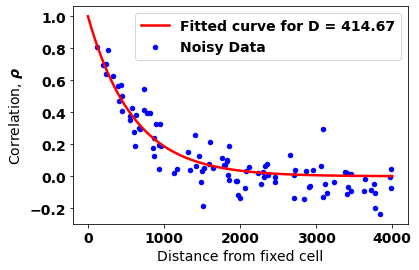

In [254]:
#set standard error, e
e = 0.1

# LPS: I've un-hardcoded the maximum distance at which we sample data. 
MaxDistance = 4000

#a function that generates n random samples, with distance values of a given range
def generate_random_samples(n,lower_bound,upper_bound,err): 
    x = []
    y = []
    for i in range(n): 
        d= np.random.uniform(lower_bound,upper_bound) #generate random distance value from fixed cell as a sample from a uniform distribution, in the range L.B. to U.B.
        rho_noisy = generate_value(d,err)
        
        x.append(d)
        y.append(rho_noisy)
    return (x,y)



#Generate scatter plot of distance vs correlation, with random colors to help differentiate overlapping points. 
m = 100 #number of samples
x,y = generate_random_samples(m,0,MaxDistance,e) #pass distance bounds and st. error
plt.figure(0)
plt.scatter(x,y, c='blue', s=20) 

plt.xlabel("Distance from fixed cell")
plt.ylabel(r'Correlation, $\rho$')
#plt.title("Scatter plot of generated distance and correlation values")
rp0 = np.random.uniform(100,1000) #sample initial random guess of D-hat for curve fitting
params, covs = optimize.curve_fit(cordist, xdata = x, ydata = y, p0=rp0) #fit curve with generated data and initial guess for parameter as 400km

print("D-hat estimate: ", params) #this prints the value of b (corr. distance) estimated from the curve fit on the generated data
print("covariance: ", covs)

#Plot the fitted curve by calculating y values based on rho without noise
axis_d = np.array(range(MaxDistance)) #prepare the axis for the fitted line
yfit = 2**(-axis_d/params[0]) #use the estimated D-hat for the fitted line
plt.plot(axis_d, yfit, c='red',linewidth='2.5')
l_strg = "Fitted curve for " + "D" + " = " + str(round(params[0],2))
plt.legend((l_strg,'Noisy Data'))



As shown above, the data follows the negative exponential shape, with some noise, as expected. The output "params:" gives the estimated value $\hat{D}$, correlation distance based on the curve fitted on the generated data.

<h2>Random sampling with different sample sizes</h2>

Next, we repeat the random sampling procedure 500 times, by looping over the number of samples taken, *m*, and investigating the effect on the resulting correlation distance estimated by the fitted curve. Here, we plot the resulting $\hat{D}$ estimate from the curve fit against the number of samples used to fit the curve, $m$.

Text(0, 0.5, 'covariance estimate')

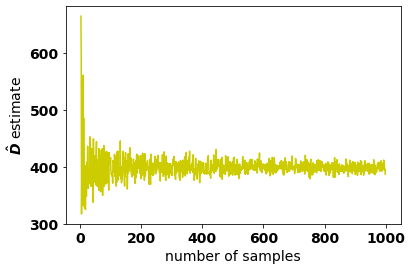

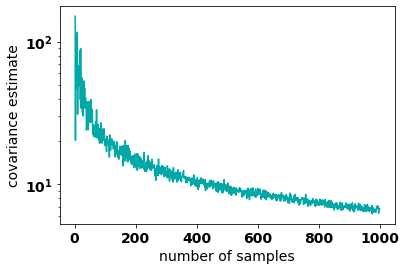

In [255]:
#set variables used to store parameter estimates

iterations = 1000 #the maximum number of samples to generate. Each iteration i will generate i samples.
sample_size = [] #this list is used as the axis in the plot, as we start from 2 and not 0.
Dhat_arr_rnd = [] #store D-hat estimate per sampling iteration
cov_arr_rnd = [] #store covariance estiamte per sampling iteration
#np.random.seed(0)


#generate random samples, with sample size "n" equal to each iteration number
for i in range(2,iterations):   
    sample_size.append(i)   #this list will be used as the x-axis in the plots, and it should start from sample size = 2
    x,y = generate_random_samples(i,0,MaxDistance,e)     #generate i samples, with each distance value being within the range [0,1000], and st. error = e
    params, covs = optimize.curve_fit(cordist, xdata = x, ydata = y, p0=rp0)    #fit curve with generated data and initial guess for parameter as 400km

    Dhat_arr_rnd.append(params[0]) #append the D-hat estimate to the D-hat array
    cov_arr_rnd.append(sqrt(covs[0][0])) #do the same for the covariance array


#we begin plotting D-hat and covariance against the sample size
plt.figure(1)
plt.plot(sample_size,Dhat_arr_rnd,color=(204/255, 204/255, 0/255) )

plt.ylabel('$\hat{D}$ estimate')
plt.xlabel('number of samples') 

plt.figure(2)
plt.plot(sample_size,cov_arr_rnd, c=(0, 168/255, 168/255))
plt.xlabel('number of samples')
plt.yscale('log')
plt.ylabel('covariance estimate')

From the results of the first graph, it seems like after a certain sample size $m$, the oscillations in $\hat{D}$ start being dampened.

For the second graph, covariance oscillates greatly but then dampens dramatically after a certain $m$.

<h2>New Algorithm: Adjusted Binary Search</h2>

The code below is used to investigate Laurens' proposed sampling strategy. The code was written as close to Laurens' vision as possible, given that grid cells are missing and artificial data is being generated on-the-fly. When one sample is taken between two distances, the mean value is used. Conversely, when two values are required, the first and third quartile are used for consistency (given that the arithmetic mean is the second quartile).

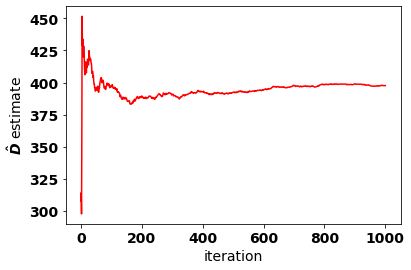

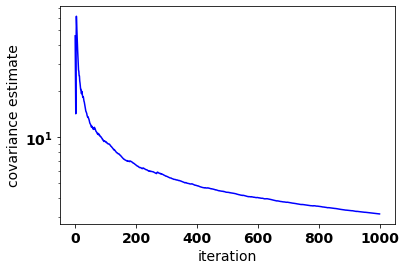

In [256]:
Dhat_arr = []
cov_arr = []
#np.random.seed(0)

# LPS: I've now made the bounds a constant that you can change easily
LowerBound = 100
UpperBound = MaxDistance#1000

p_low = generate_value(LowerBound,e) #generate values for rho for distances 100km and 1000km using the neg. exp. model (again, with noise)
p_upper = generate_value(UpperBound,e)

x = [LowerBound,UpperBound]
y = [p_low,p_upper] #store distance and rho values in lists for easy plotting


params, covs = optimize.curve_fit(cordist, xdata = x, ydata = y, p0=rp0) #fit the curve onto the 2 data points and get D-hat and covariance estimates


Dhat_arr.append(params[0]) #Dhat_arr[0] becomes our first estimate for correlation distance
cov_arr.append(sqrt(covs[0][0])) #we also store covariance to plot later
#Now take the mean:

m1 = (LowerBound+Dhat_arr[0]) * 0.5
m2 = (UpperBound+Dhat_arr[0]) * 0.5

#Calculate correlation for each new distance value and fit curve on these two + previous two points:

m1_rho = generate_value(m1,e)
m2_rho = generate_value(m2,e)

x.append(m1)
y.append(m1_rho)
x.append(m2)
y.append(m2_rho)

params, covs = optimize.curve_fit(cordist, xdata = x, ydata = y, p0=rp0) #fit the curve onto the 2 data points and get D-hat and covariance estimates

Dhat_arr.append(params[0]) #new estimate of correlation distance, D-hat
cov_arr.append(sqrt(covs[0][0]))

i_arr = [0,1]  #used as x axis to plot iteration number. the loop will start from iteration no. 1(not 0) and the list will be updated each time.

for i in range(1,iterations):
    i_arr.append(i+1) #update every iteration
    
    if Dhat_arr[i] < Dhat_arr[i-1]: #take two distances between Dhat[i] and 100. We used mean for one distance, but for two we will use 1st and 3rd quartile.
        q1 = (Dhat_arr[i]+LowerBound)*0.25
        q1_rho = generate_value(q1,e)
        q3 = (Dhat_arr[i]+LowerBound)*0.75
        q3_rho = generate_value(q3,e)
        

        #take one point between Dhat[i] and 1000. We can use mean for a single point.
        m1 = (Dhat_arr[i]+UpperBound) * 0.5
        m1_rho = generate_value(m1,e)

    else: #vice versa; take quartiles between Dhat[i] and 1000, and median between Dhat[i] and 100.
        q1 = (Dhat_arr[i]+UpperBound)*0.25
        q1_rho = generate_value(q1,e)
        q3 = (Dhat_arr[i]+UpperBound)*0.75
        q3_rho = generate_value(q3,e)

        m1 = (Dhat_arr[i]+LowerBound) * 0.5
        m1_rho = generate_value(m1,e)
    
    x.append(q1)        #append all distance-correlation pairs to the correct x and y lists
    y.append(q1_rho)
    x.append(q3)
    y.append(q3_rho)
    x.append(m1)
    y.append(m1_rho)


    params, covs = optimize.curve_fit(cordist, xdata = x, ydata = y, p0=rp0) #fit the curve onto the 2 data points and get D-hat and covariance estimates
    Dhat_arr.append(params[0]) #new estimate of corr. dist added to D-hat list
    cov_arr.append(sqrt(covs[0][0]))



plt.figure(3)
plt.plot(i_arr,Dhat_arr, c='red' ) 

plt.ylabel('$\hat{D}$ estimate')
plt.xlabel('iteration') 

plt.figure(4)
plt.plot(i_arr,cov_arr,color='blue')
plt.xlabel('iteration')
plt.ylabel('covariance estimate')
plt.yscale('log')


<h2>Adjusted Binary Search: Version 2</h2>

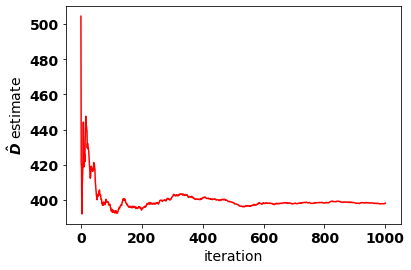

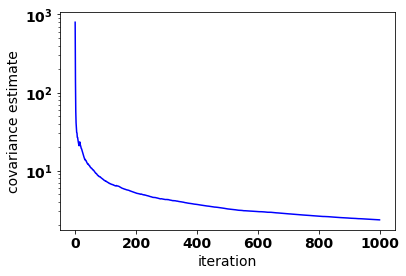

In [257]:
Dhat_arr2 = []
cov_arr2 = []
#np.random.seed(0)

# LPS: I've now made the bounds a constant that you can change easily
LowerBound = 100
UpperBound = MaxDistance#1000

p_low = generate_value(LowerBound,e) #generate values for rho for distances 100km and 1000km using the neg. exp. model (again, with noise)
p_upper = generate_value(UpperBound,e)

x = [LowerBound,UpperBound]
y = [p_low,p_upper] #store distance and rho values in lists for easy plotting


params, covs = optimize.curve_fit(cordist, xdata = x, ydata = y, p0=rp0) #fit the curve onto the 2 data points and get D-hat and covariance estimates


Dhat_arr2.append(params[0]) #Dhat_arr[0] becomes our first estimate for correlation distance
cov_arr2.append(sqrt(covs[0][0])) #we also store covariance to plot later
#Now take the mean:

m1 = (LowerBound+Dhat_arr2[0]) * 0.5
m2 = (UpperBound+Dhat_arr2[0]) * 0.5

#Calculate correlation for each new distance value and fit curve on these two + previous two points:

m1_rho = generate_value(m1,e)
m2_rho = generate_value(m2,e)

x.append(m1)
y.append(m1_rho)
x.append(m2)
y.append(m2_rho)

params, covs = optimize.curve_fit(cordist, xdata = x, ydata = y, p0=rp0) #fit the curve onto the 2 data points and get D-hat and covariance estimates

Dhat_arr2.append(params[0]) #new estimate of correlation distance, D-hat
cov_arr2.append(sqrt(covs[0][0]))

i_arr = [0,1]  #used as x axis to plot iteration number. the loop will start from iteration no. 1(not 0) and the list will be updated each time.

for i in range(1,iterations):
    i_arr.append(i+1) #update every iteration

    mid_Dhat = 0.5 * (Dhat_arr2[i] + Dhat_arr2[i-1])
    rho_mid_Dhat = generate_value(mid_Dhat,e)
    x.append(mid_Dhat)
    y.append(rho_mid_Dhat)
    
    if Dhat_arr2[i] < Dhat_arr2[i-1]: #take two distances between Dhat[i] and 100. We used mean for one distance, but for two we will use 1st and 3rd quartile.
        q1 = (Dhat_arr[i]+LowerBound)*0.25
        q1_rho = generate_value(q1,e)
        q3 = (Dhat_arr[i]+LowerBound)*0.75
        q3_rho = generate_value(q3,e)
        

        #take one point between Dhat[i] and 1000. We can use mean for a single point.
        m1 = (Dhat_arr2[i]+UpperBound) * 0.5
        m1_rho = generate_value(m1,e)

    else: #vice versa; take quartiles between Dhat[i] and 1000, and median between Dhat[i] and 100.
        q1 = (Dhat_arr2[i]+UpperBound)*0.25
        q1_rho = generate_value(q1,e)
        q3 = (Dhat_arr2[i]+UpperBound)*0.75
        q3_rho = generate_value(q3,e)

        m1 = (Dhat_arr2[i]+LowerBound) * 0.5
        m1_rho = generate_value(m1,e)
    
    x.append(q1)        #append all distance-correlation pairs to the correct x and y lists
    y.append(q1_rho)
    x.append(q3)
    y.append(q3_rho)
    x.append(m1)
    y.append(m1_rho)


    params, covs = optimize.curve_fit(cordist, xdata = x, ydata = y, p0=rp0) #fit the curve onto the 2 data points and get D-hat and covariance estimates
    Dhat_arr2.append(params[0]) #new estimate of corr. dist added to D-hat list
    cov_arr2.append(sqrt(covs[0][0]))


plt.figure(5)
plt.plot(i_arr,Dhat_arr2, c='red' ) 

plt.ylabel('$\hat{D}$ estimate')
plt.xlabel('iteration') 

plt.figure(6)
plt.plot(i_arr,cov_arr2,color='blue')
plt.xlabel('iteration')
plt.ylabel('covariance estimate')
plt.yscale('log')

From the results above, $\hat{D}$ estimates oscillate at smaller sample sizes (corresponding to iteration number, as we add 3 new samples per iteration) but start plateauing. The damping effect is much stronger here than for the random sampling approach.

The covariance estimates also oscillate initially but then dampen quickly and reach a smooth, low plateau.

<h2>Comparing Results</h2>

Laurens' Sampling and Random Sampling results are compared below.

p0 value: 339.26235510104016
error value: 0.1


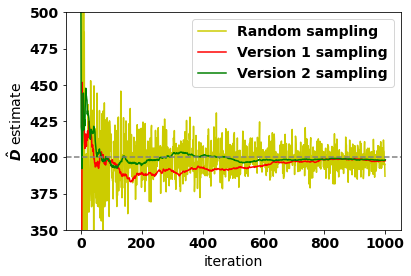

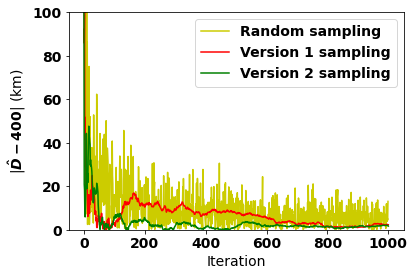

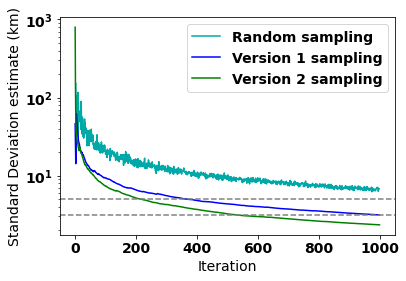

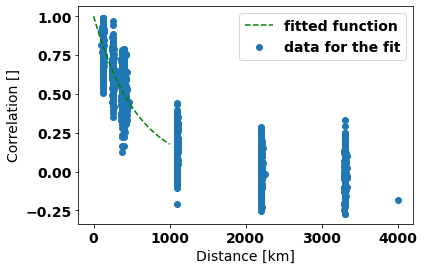

In [258]:
print("p0 value:",rp0)
print("error value:",e)
plt.figure(5)
plt.plot(sample_size,Dhat_arr_rnd, c=(204/255, 204/255, 0/255) )
plt.plot(i_arr,Dhat_arr, c='red' )
plt.plot(i_arr,Dhat_arr2, c='green' )


# LPS: Added a line at the TRUE value
plt.axhline(y=ValueTRUE, color='gray', linestyle='--')

# LPS: Limiting the Y-axis range
plt.ylim([ValueTRUE-50,ValueTRUE+100])

plt.ylabel('$\hat{D}$ estimate')
plt.xlabel('iteration')  
plt.legend(('Random sampling','Version 1 sampling','Version 2 sampling'),loc="upper right")


#plot difference from true value
Dhat_arr_rnd_diff = [abs(i-ValueTRUE) for i in Dhat_arr_rnd] 
Dhat_arr_diff = [abs(i-ValueTRUE) for i in Dhat_arr] 
Dhat_arr2_diff = [abs(i-ValueTRUE) for i in Dhat_arr2]

#plot absolute difference (Dhat and actual true value of D)
plt.figure(8)
plt.plot(sample_size,Dhat_arr_rnd_diff, c=(204/255, 204/255, 0/255) )
plt.plot(i_arr,Dhat_arr_diff, c='red' )
plt.plot(i_arr,Dhat_arr2_diff, c='green' )
#plt.axhline(y=0, color='gray', linestyle='--')
plt.ylim([0,+100])
plt.ylabel('|$\hat{D} - 400$| (km)')
plt.xlabel('Iteration')  
plt.legend(('Random sampling','Version 1 sampling','Version 2 sampling'),loc="upper right")



plt.figure(6)
plt.plot(sample_size,cov_arr_rnd, color=(0, 168/255, 168/255) )
plt.plot(i_arr,cov_arr, c='blue' ) 
plt.plot(i_arr,cov_arr2, c='green' ) 
plt.axhline(y=sqrt(10), color='gray', linestyle='--')
plt.axhline(y=sqrt(25), color='gray', linestyle='--')
plt.yscale('log')
#plt.ylim([10**0,10**5])
plt.ylabel('Standard Deviation estimate (km)') # LPS: As there is only one variable, this is the variance of this variable. 
plt.xlabel('Iteration')  
plt.legend(('Random sampling','Version 1 sampling','Version 2 sampling'),loc="upper right")








# LPS: added figure on the samples drawn by the end
plt.figure(7)
plt.scatter(x,y, label='data for the fit')
plt.plot(np.arange(1000), cordist(np.arange(1000), *params), 'g--',label='fitted function')
plt.ylabel('Correlation []') 
plt.xlabel('Distance [km]')  
plt.legend(loc="upper right")

NB! LPS: We see in the first figure that the Estimate from our code has a consisten underestimation of the Correlation Distance. We need to look into that! 

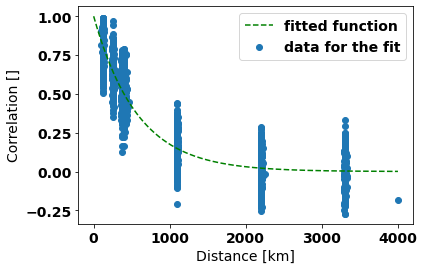

In [259]:
plt.figure(7)
plt.scatter(x,y, label='data for the fit')
plt.plot(np.arange(4000), cordist(np.arange(4000), *params), 'g--',label='fitted function')
plt.ylabel('Correlation []') 
plt.xlabel('Distance [km]')  
plt.legend(loc="upper right")